In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

# Linear Regression Using Galton Dataset

## Introduction with the Galton dataset

We introduce the linear regression using the famous Galton dataset

In [2]:
# load dataset
df = sm.datasets.get_rdataset('GaltonFamilies', package='HistData').data

X: childAdjustedHeight

Y: midparentHeight

In [3]:
# account for the gender difference on children's height: female height*1.08
df['childAdjustedHeight'] = df['childHeight']
df['childAdjustedHeight'][df['gender']=='female'] = df['childAdjustedHeight'][df['gender']=='female']*1.08

x = df['childAdjustedHeight'].values # children's height
y = df['midparentHeight'].values # parent's height

Galton studied the data by defining bins of parents' heights and calculated the mean child's height for each bin. Below, the binned means are shown and plotted.

In [4]:
minX = 64
maxX = 75
minY = 64
maxY = 74

x_intervals = np.linspace(minX,maxX,endpoint = True, num = (maxX-minX)+1)
y_intervals = np.linspace(minY,maxY,endpoint = True, num = (maxY-minY)+1)

In [5]:
y_mean_interval = np.zeros(len(x_intervals)-1)
y_num_sample = np.zeros(len(x_intervals)-1)
for i in range(len(x_intervals)-1):
    y_num_sample[i] = len(y[(x_intervals[i]<=x) & (x<x_intervals[i+1])])
    y_mean_interval[i] = np.mean(y[(x_intervals[i]<=x) & (x<x_intervals[i+1])])

x_mean_interval = np.zeros(len(y_intervals)-1)
x_num_sample = np.zeros(len(y_intervals)-1)
for i in range(len(y_intervals)-1):
    x_num_sample[i] = len(x[(y_intervals[i]<=y) & (y<y_intervals[i+1])])
    x_mean_interval[i] = np.mean(x[(y_intervals[i]<=y) & (y<y_intervals[i+1])])

In [38]:
pd.DataFrame(np.round(y_mean_interval,2).reshape(1,-1),
             columns = [x_intervals[i] for i in range(len(x_intervals)-1)],
             index = ['y_mean_value'])

,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0
y_mean_value,67.54,67.99,68.46,68.5,68.82,69.21,69.36,69.84,70.06,71.0,71.97


In [39]:
pd.DataFrame(np.round(x_mean_interval,2).reshape(1,-1),
             columns = [y_intervals[i] for i in range(len(y_intervals)-1)],
             index = ['x_mean_value'])

,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0
x_mean_value,66.1,66.64,67.8,68.33,68.57,69.13,70.18,70.72,71.21,73.26


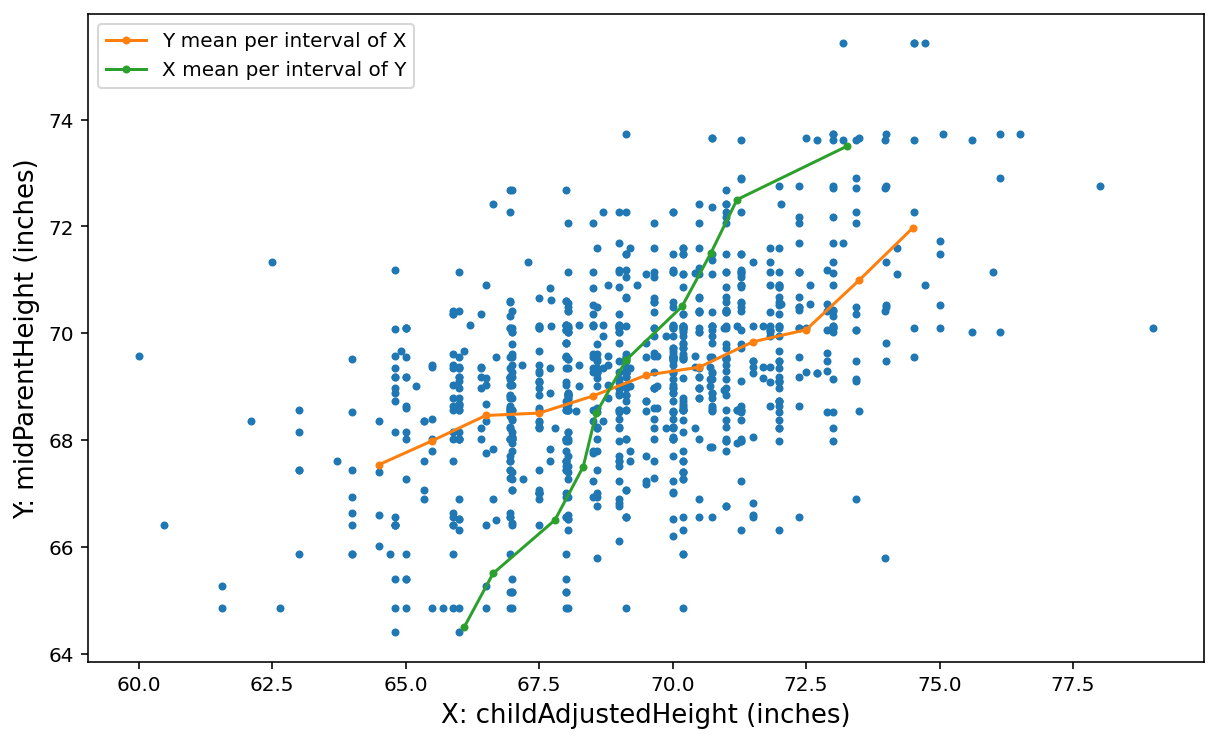

In [37]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'.')
plt.plot(x_intervals[:-1]+0.5,y_mean_interval,'.-',label = 'Y mean per interval of X')
plt.plot(x_mean_interval,y_intervals[:-1]+0.5,'.-',label = 'X mean per interval of Y')
plt.xlabel('X: childAdjustedHeight (inches)',fontsize=13)
plt.ylabel('Y: midParentHeight (inches)',fontsize=13)
plt.legend()
plt.gca().set(
    aspect="equal"
)
plt.show()

## Fiting the linear function

$Y = \beta_0 + \beta_1*X+\epsilon$

In [24]:
import statsmodels.formula.api as smf

In [25]:
# Regression 1: Y ~ aX+b
# reg0 = LinearRegression().fit(x.reshape(-1,1), y)
reg0 = smf.ols(formula='midparentHeight ~ childAdjustedHeight', data=df).fit()

# Regression 2: X ~ cY+d
# reg1 = LinearRegression().fit(y.reshape(-1,1), x)
reg1 = smf.ols(formula='childAdjustedHeight ~ midparentHeight', data=df).fit()

In [22]:
# Orthogonal regression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.array([x,y]).T)
PCA(n_components=2)
orth_y = (pca.components_[0][1]/pca.components_[0][0])*(x-np.mean(x)) + np.mean(y)

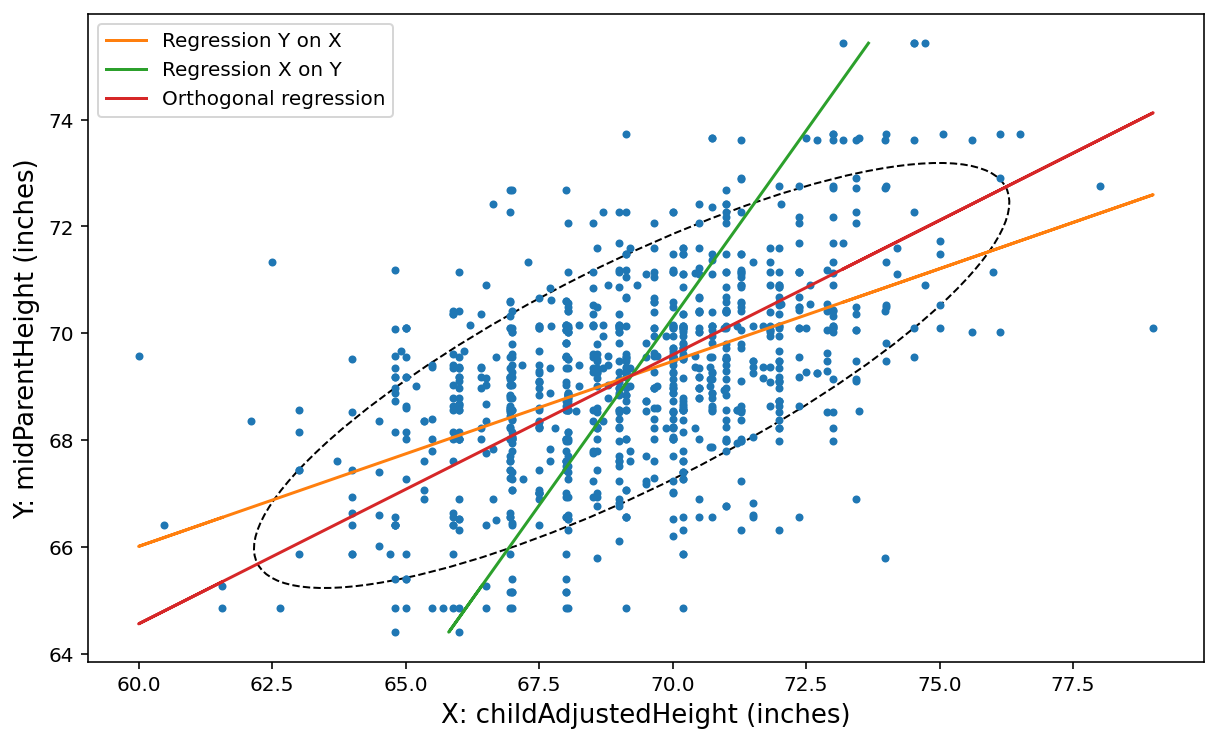

In [41]:
fig, ax = plt.subplots(figsize = [10,6])
ax.plot(x,y,'.')

plt.plot(x, reg0.predict(exog=dict(childAdjustedHeight=x)),label = 'Regression Y on X')
plt.plot(reg1.predict(exog=dict(midparentHeight=y)), y, label = 'Regression X on Y')

ax.plot(x,orth_y,label = 'Orthogonal regression')
mean = [np.mean(x),np.mean(y)]
width = pca.explained_variance_[0]*2
height = pca.explained_variance_[1]*2
angle = np.tanh(pca.components_[0][1]/pca.components_[0][0])*180/np.pi
ell = mpl.patches.Ellipse(xy=mean, width=width, height=height, angle = angle,
                          facecolor='none',edgecolor='black',linestyle = '--')
ax.add_patch(ell)
ax.set_xlabel('X: childAdjustedHeight (inches)',fontsize=13)
ax.set_ylabel('Y: midParentHeight (inches)',fontsize=13)
ax.legend()
plt.gca().set(
    aspect="equal"
)
plt.show()

In [40]:
print(reg0.summary())

                            OLS Regression Results                            
Dep. Variable:        midparentHeight   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     305.8
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           2.00e-59
Time:                        14:28:59   Log-Likelihood:                -1742.5
No. Observations:                 934   AIC:                             3489.
Df Residuals:                     932   BIC:                             3499.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              45.2067    

## Assesment of residuals

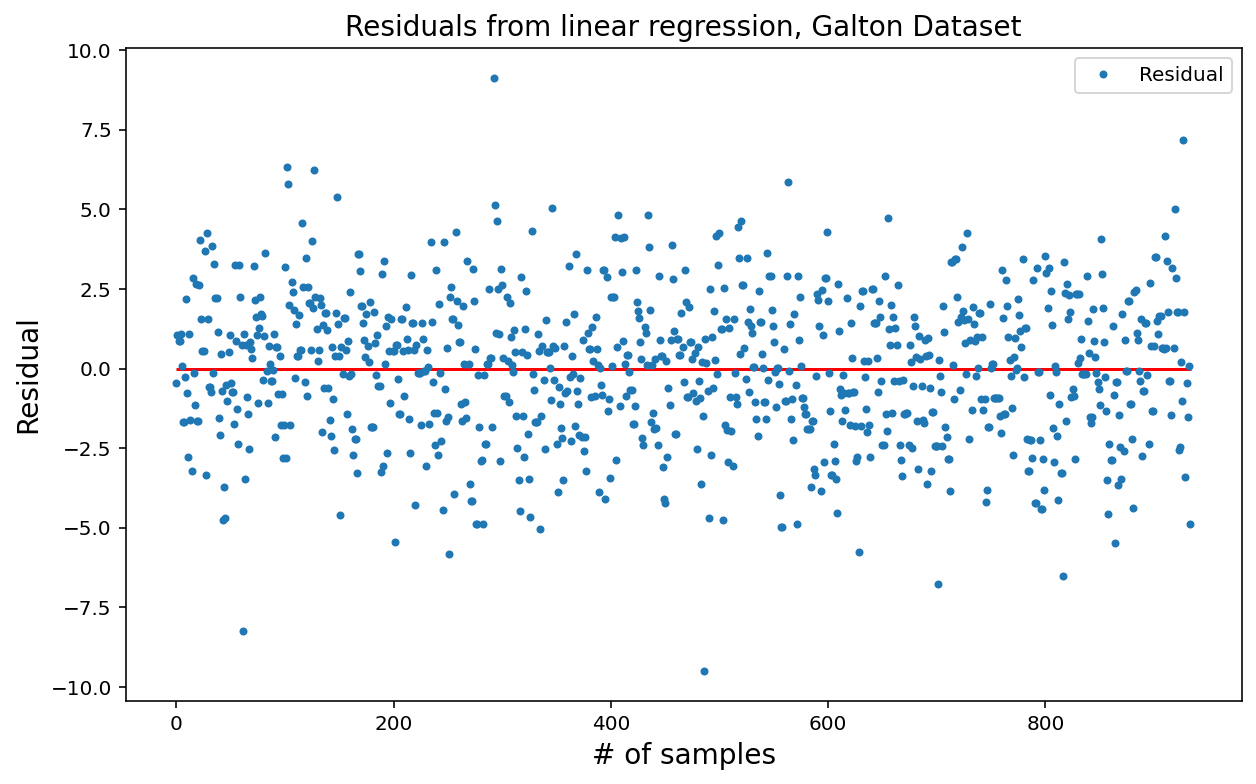

In [62]:
fig, ax = plt.subplots(figsize = [10,6])
plt.plot(reg1.resid,'.', label = 'Residual')
plt.hlines(y = 0, xmin = 0, xmax = len(x), color = 'r')
plt.xlabel('# of samples',fontsize=14)
plt.ylabel('Residual',fontsize=14)
plt.title('Residuals from linear regression, Galton Dataset',fontsize=14)
plt.legend(loc="best")
plt.show()

## Least sqaure as a function of $\beta_0$ and $\beta_1$

In [52]:
from tqdm.notebook import tqdm
x = df['childAdjustedHeight'].values # children's height
y = df['midparentHeight'].values # parent's height
# Y ~ aX+b
n_sampls = 500
a_max = 1
a_min = -0.2
b_max = 80
b_min = 0
coeffs = np.linspace(a_min,a_max,n_sampls)
intercepts = np.linspace(b_min,b_max,n_sampls)
S_ab = []
for b in tqdm(intercepts):
    S_b = []
    for a in coeffs:
        y_prd = a*x+b
        s = np.sum((y_prd-y)**2)
        S_b.append(s)
    S_ab.append(np.asarray(S_b))

S_ab = np.asarray(S_ab)

  0%|          | 0/500 [00:00<?, ?it/s]

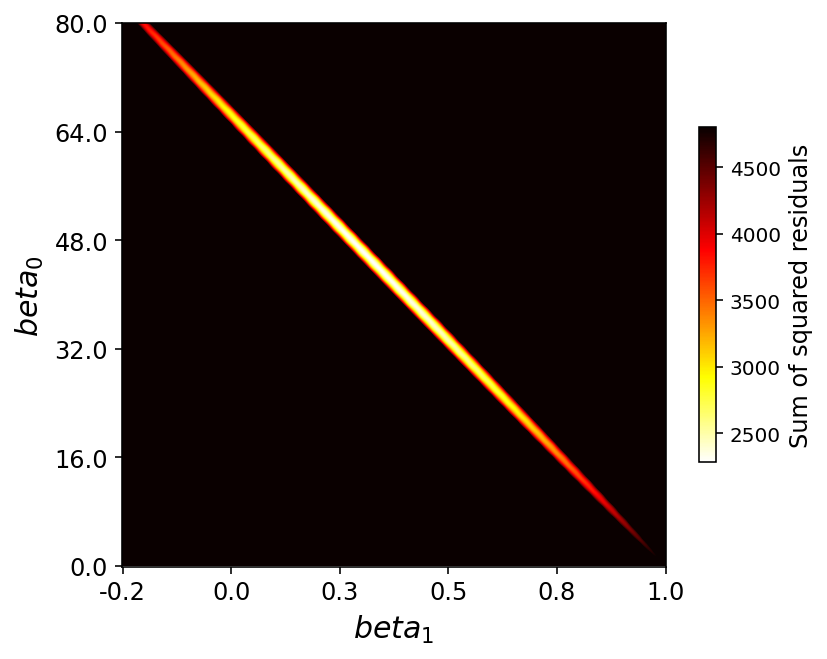

In [53]:
# extent=(a_min, a_max, b_min,b_max)
plt.figure(figsize=(6,5))
plt.imshow(S_ab, cmap='hot_r', origin='lower', vmax=0.48e4)
plt.xticks(np.arange(0, n_sampls+1, 100), np.round(np.linspace(a_min,a_max, 6), 1), fontsize=12)
plt.yticks(np.arange(0, n_sampls+1, 100), np.round(np.linspace(b_min,b_max, 6), 1), fontsize=12)

plt.ylabel('$beta_0$', fontsize=15), plt.xlabel('$beta_1$', fontsize=15)
# plt.title('Least square as function of $a$ and $b$', fontsize=15)
cbar = plt.colorbar(fraction=0.025)
cbar.set_label('Sum of squared residuals', fontsize=12)
plt.show()

## Expressing confidence by Boostraping

We contiutne with a bootstrap analysis to evaluate the uncertainty of coefficients and intercepts. 

In the bootstrap analysis, we resample the Galton data with replacement. The size of resample is the dataset original size. Here, we perform 1000 times resampling. You can also test by increasing/decreasing the resampling times. 

In [114]:
# size of the bootstrap resampling
size = len(x)
# Determine how many times of resampling
n = 1000

Runing boostraping

In [100]:
beta_0 = []
beta_1 = []
for i in tqdm(range(n)):
    smpl_idx = np.random.choice(np.arange(len(x)), size = size)
    bootrap_df = df.loc[smpl_idx]
    linear_reg = smf.ols(formula='midparentHeight ~ childAdjustedHeight', data=bootrap_df).fit()
    beta_0.append(linear_reg.params.childAdjustedHeight)
    beta_1.append(linear_reg.params.Intercept)
beta_0 = np.asarray(beta_0)
beta_1 = np.asarray(beta_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot the uncertainty of coefficient and intercept

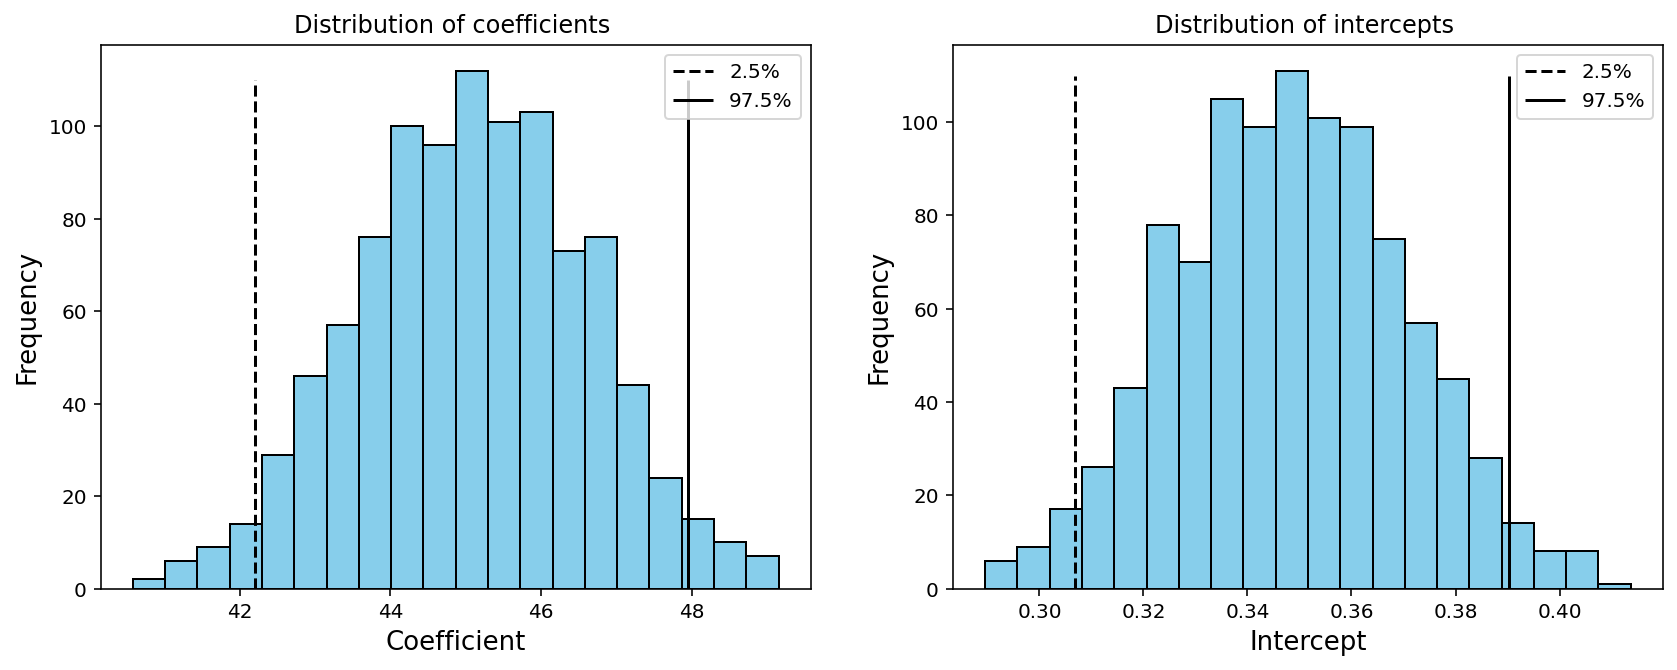

In [127]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(beta_1, bins=20, edgecolor='k', color='skyblue')
plt.title('Distribution of coefficients ')
plt.ylabel('Frequency',fontsize=13), plt.xlabel('Coefficient',fontsize=13)
plt.vlines(x=np.quantile(beta_1, 0.025), ymin=0, ymax=110, colors='k', linestyles='--', label='2.5%')
plt.vlines(x=np.quantile(beta_1, 0.975), ymin=0, ymax=110, colors='k', linestyles='-', label='97.5%')
plt.legend()
plt.subplot(122)
plt.hist(beta_0, bins=20, edgecolor='k', color='skyblue')
plt.title('Distribution of intercepts ')
plt.ylabel('Frequency',fontsize=13), plt.xlabel('Intercept',fontsize=13)
plt.vlines(x=np.quantile(beta_0, 0.025), ymin=0, ymax=110, colors='k', linestyles='--', label='2.5%')
plt.vlines(x=np.quantile(beta_0, 0.975), ymin=0, ymax=110, colors='k', linestyles='-', label='97.5%')
plt.legend()
plt.show()

We further evaluate the prediction uncertainty of the fitted linear regression model. Here, we plot the 95% confidence interval around the mean. The 95% prediction interval is also added in the plot. 

In [240]:
# Define 'alpha': the significance level for the confidence interval. 
# ie. `alpha` = .05 returns a 95% confidence interval.
alpha = 0.05

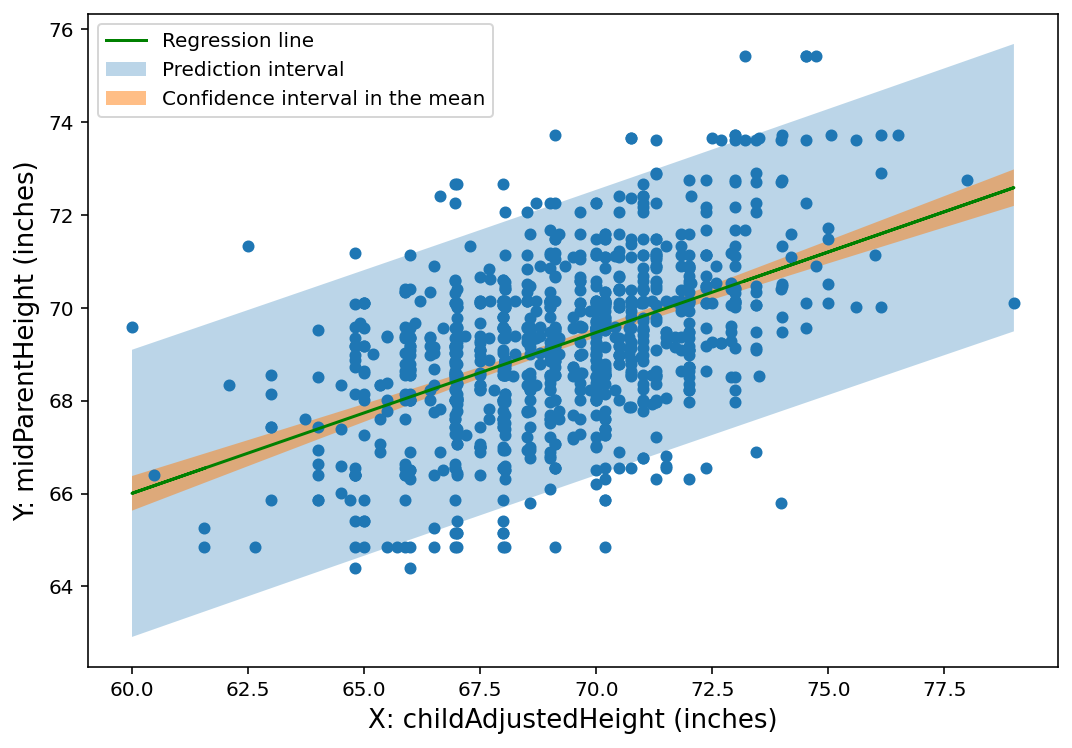

In [242]:
# Generate linear space sampled data of X
x_CI = np.linspace(x.min(), x.max(), 1000)
y_CI = np.linspace(y.min(), y.max(), 1000)
# Calculate confidence interval
df_CI = pd.DataFrame(data=np.c_[x_ci, y_ci], columns=['childAdjustedHeight','midparentHeight'])
predictions_CI = reg0.get_prediction(df_ci).summary_frame(alpha)

fig, ax = plt.subplots(figsize = [10,6])
ax.plot(x,y,'.', markersize=10)

plt.plot(x, reg0.predict(exog=dict(childAdjustedHeight=x)), c='g', label='Regression line')
plt.fill_between(df_CI['childAdjustedHeight'], predictions_CI['obs_ci_lower'], 
                 predictions_CI['obs_ci_upper'], alpha=.3, label='Prediction interval')
plt.fill_between(df_CI['childAdjustedHeight'], predictions_CI['mean_ci_lower'], 
                 predictions_CI['mean_ci_upper'], alpha=.5, label='Confidence interval in the mean')

ax.set_xlabel('X: childAdjustedHeight (inches)',fontsize=13)
ax.set_ylabel('Y: midParentHeight (inches)',fontsize=13)
ax.legend()
plt.gca().set(
    aspect="equal"
)
plt.show()

Script reference note: https://lmc2179.github.io/posts/confidence_prediction.html